<a href="https://colab.research.google.com/github/rachelngordon/BookQuotesAnalysis/blob/main/BookQuotesLDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling of Book Quotes using LDA

Sources: 

https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
https://maartengr.github.io/BERTopic/getting_started/topicsperclass/topicsperclass.html

## Import the data from Google Drive

In [168]:
# authenticate google user
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# import packages
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [169]:
# import data from google sheet
worksheet = gc.open('BookQuotes').sheet1

rows = worksheet.get_all_values()

df = pd.DataFrame.from_records(rows[1:], columns = rows[0])

# if running on a local computer
#df = pd.read_excel('BookQuotes.xlsx')

In [170]:
# view the data
df.head()

,Text,Book,Author,Date
0,"Today the successes are less spectacular, the cries harder to deny, the promise of utopia ""just ...",The Ascent of Humanity,Charles Eisenstein,12/27/2021
1,"As relationships develop, the human brain gains an increasingly sophisticated understanding of o...",Newsmakers: Artificial Intelligance and the Future of Journalism,Francesco Marconi,12/27/2021
2,"Language is our portal to meaning-making, connection, healing, learning, and self-awareness. Hav...",Atlas of the Heart,Brene Brown,12/27/2021
3,"Our understanding of...emotions is shaped by how we perceive, categorize, and describe emotional...",Atlas of the Heart,Brene Brown,12/27/2021
4,"Emotions are the description of intangible human feelings, the powerful internal sensations that...",Atlas of the Heart,Brene Brown,12/27/2021


## Text Preprocessing

In [171]:
## Clean the text
def text_cleaning(text):
  

  # remove punctuation
  text = re.sub(r"\\n", " ", text)
  text = "".join([char for char in text if char not in string.punctuation])
  
  # convert to lowercase
  text = text.lower()
            
  # tokenization (second one removes emojis)
  word_tokens = nltk.word_tokenize(text)
        
  # remove stop words
  non_stopwords = [word for word in word_tokens if word not in stopwords.words('english') and word not in ['one']] # can adjust second list to exclude words
  text = " ".join(non_stopwords)

    
  return text
    

In [172]:
# clean book quotes and add new column to dataframe
clean_quotes = []
for quote in df['Text']:
  clean_quotes.append(text_cleaning(quote))

df['Clean_Text'] = clean_quotes

In [173]:
# if interested in one particular book
#df = df[df['Book'] == 'The Anthropocene Reviewed']

# view new data
df.head()

,Text,Book,Author,Date,Clean_Text
0,"Today the successes are less spectacular, the cries harder to deny, the promise of utopia ""just ...",The Ascent of Humanity,Charles Eisenstein,12/27/2021,today successes less spectacular cries harder deny promise utopia around corner hollow still act...
1,"As relationships develop, the human brain gains an increasingly sophisticated understanding of o...",Newsmakers: Artificial Intelligance and the Future of Journalism,Francesco Marconi,12/27/2021,relationships develop human brain gains increasingly sophisticated understanding anothers speech...
2,"Language is our portal to meaning-making, connection, healing, learning, and self-awareness. Hav...",Atlas of the Heart,Brene Brown,12/27/2021,language portal meaningmaking connection healing learning selfawareness access right words open ...
3,"Our understanding of...emotions is shaped by how we perceive, categorize, and describe emotional...",Atlas of the Heart,Brene Brown,12/27/2021,understanding ofemotions shaped perceive categorize describe emotional experiences
4,"Emotions are the description of intangible human feelings, the powerful internal sensations that...",Atlas of the Heart,Brene Brown,12/27/2021,emotions description intangible human feelings powerful internal sensations color every experience


## Exploratory Data Analysis

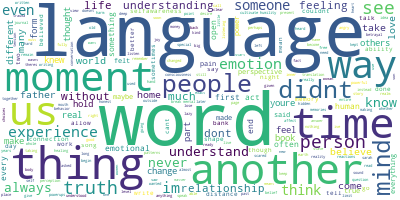

In [174]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['Clean_Text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Topic Modeling

In [175]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
data = df.Clean_Text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['today', 'successes', 'less', 'spectacular', 'cries', 'harder', 'deny', 'promise', 'utopia', 'around', 'corner', 'hollow', 'still', 'act', 'though', 'control', 'answer']


In [176]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]


In [177]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

[(0,
  '0.015*"language" + 0.010*"never" + 0.010*"words" + 0.007*"pain" + '
  '0.007*"information" + 0.007*"idaho" + 0.007*"im" + 0.005*"question" + '
  '0.005*"think" + 0.005*"part"'),
 (1,
  '0.010*"would" + 0.009*"could" + 0.007*"knew" + 0.007*"believed" + '
  '0.007*"break" + 0.006*"believe" + 0.006*"language" + 0.006*"words" + '
  '0.006*"time" + 0.006*"real"'),
 (2,
  '0.010*"way" + 0.010*"another" + 0.009*"time" + 0.009*"people" + 0.009*"us" '
  '+ 0.008*"would" + 0.008*"different" + 0.008*"language" + 0.008*"someone" + '
  '0.007*"change"'),
 (3,
  '0.009*"didnt" + 0.009*"shape" + 0.009*"would" + 0.008*"like" + 0.008*"us" + '
  '0.008*"mind" + 0.007*"moment" + 0.006*"made" + 0.006*"never" + '
  '0.006*"kept"'),
 (4,
  '0.021*"words" + 0.008*"relationships" + 0.008*"people" + 0.007*"part" + '
  '0.007*"language" + 0.006*"everything" + 0.006*"earth" + 0.006*"book" + '
  '0.006*"support" + 0.005*"emotional"'),
 (5,
  '0.015*"im" + 0.011*"better" + 0.011*"think" + 0.008*"words" + 0

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

## Visualization

In [178]:
import pickle 
import pyLDAvis
import os
import pyLDAvis.gensim_models as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.038874  0.091379       1        1  15.568512
8     -0.029570 -0.065738       2        1  14.259218
9      0.114298  0.094331       3        1  12.713436
1     -0.026099 -0.033652       4        1  11.741301
3     -0.061272  0.001640       5        1  11.431627
6     -0.077245  0.047485       6        1   9.132923
4      0.067291 -0.049010       7        1   9.033596
5      0.015174 -0.064828       8        1   6.240650
0      0.055615 -0.032282       9        1   5.038971
7     -0.019319  0.010674      10        1   4.839767, topic_info=           Term       Freq      Total Category  logprob  loglift
48        words  13.000000  13.000000  Default  30.0000  30.0000
171          us  10.000000  10.000000  Default  29.0000  29.0000
427          im   7.000000   7.000000  Default  28.0000  28.0000
40     language  13.000000  13.000000  Default  27.0000  27.0000
1166   humility   3.000000   3.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
73     thoughts   0.520757   3.852963  Topic10  -5.4793   1.0270
583        take   0.538935   5.210829  Topic10  -5.4450   0.7594
155     feeling   0.520756   4.252524  Topic10  -5.4793   0.9283
59        every   0.520759   4.874737  Topic10  -5.4793   0.7918
51    emotional   0.520757   4.436561  Topic10  -5.4793   0.8860

[609 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
151       1  0.237949    ability
151       2  0.475898    ability
151       9  0.237949    ability
1290      2  0.656526     accept
0         1  0.225785        act
...     ...       ...        ...
341       7  0.307823      years
987       6  0.784852       yell
988       6  0.784852     yelled
1095      8  0.861300  yesterday
132       2  0.656526     zerzan

[817 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 10, 2, 4, 7, 5, 6, 1, 8])

### Word Clouds and Counts per topic

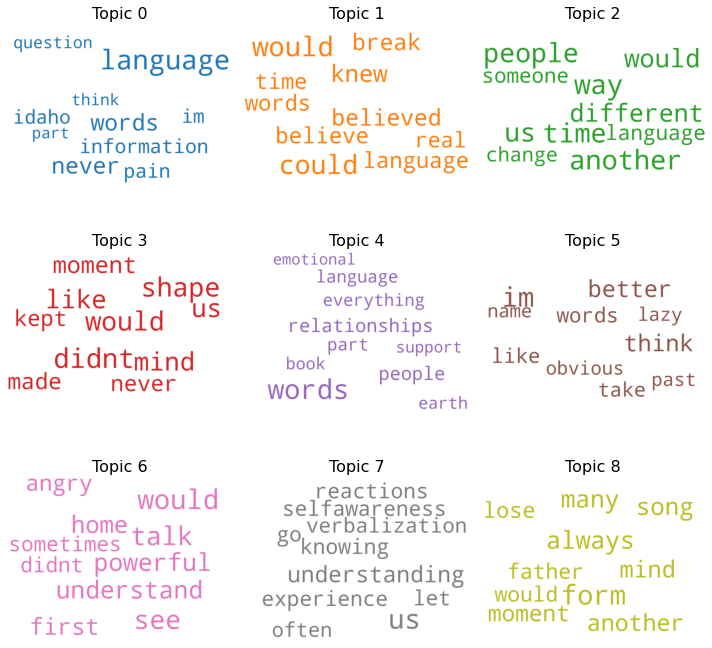

In [179]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

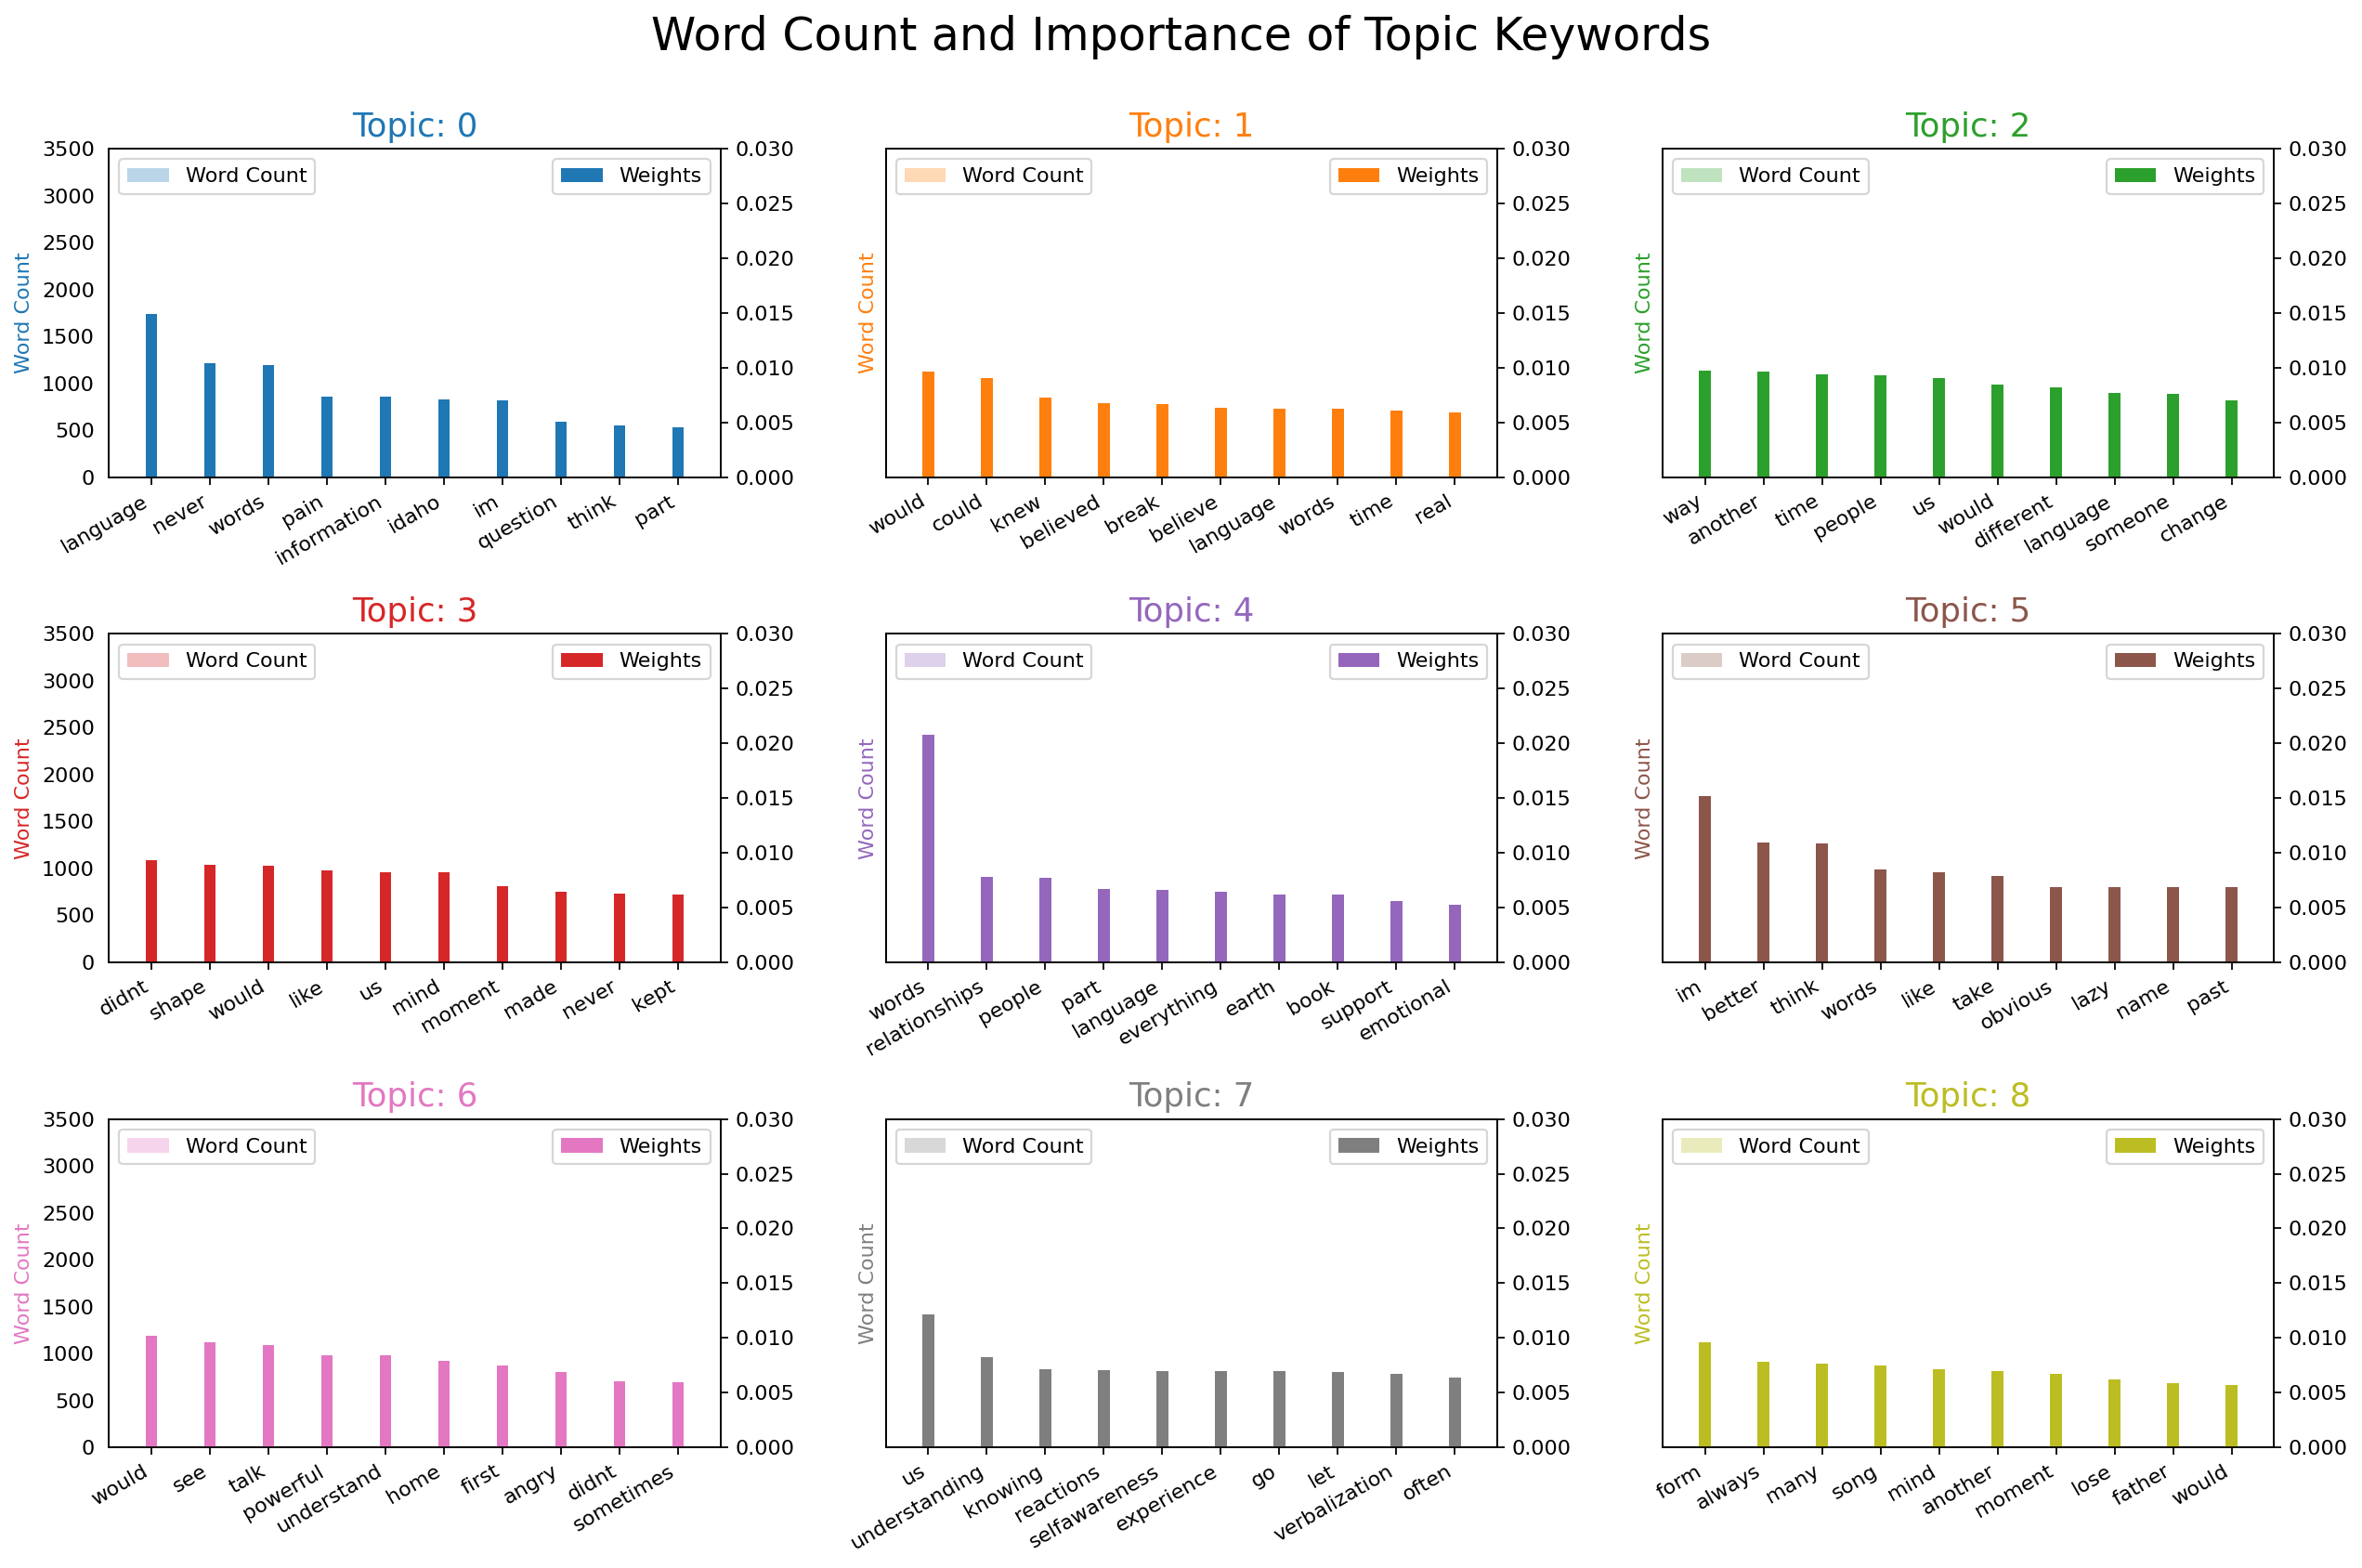

In [180]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()


### Dominant topic for each quote

In [181]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
print(df_dominant_topic.head(10))

# write to original dataframe
df["Dominant_Topic"] = df_dominant_topic["Dominant_Topic"]
df["Topic_Perc_Contrib"] = df_dominant_topic["Topic_Perc_Contrib"]
df["Keywords"] = df_dominant_topic["Keywords"]
df.to_csv('CleanQuotes.csv')

   Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             9.0              0.9500   
1            1             7.0              0.9571   
2            2             1.0              0.9357   
3            3             9.0              0.9000   
4            4             6.0              0.9250   
5            5             3.0              0.9182   
6            6             3.0              0.8200   
7            7             8.0              0.9500   
8            8             9.0              0.8500   
9            9             1.0              0.9500   

                                                                                          Keywords  \
0                       things, time, humility, cultivate, life, way, powerups, bank, people, word   
1  us, understanding, knowing, reactions, selfawareness, experience, go, let, verbalization, often   
2                        would, could, knew, believed, break, believe, language, words, time, real 

### Most representative sentence for each topic

In [183]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
print(sent_topics_sorteddf_mallet.head(10))
sent_topics_sorteddf_mallet.to_csv('Topics.csv')

   Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9743   
1        1.0              0.9833   
2        2.0              0.9800   
3        3.0              0.9873   
4        4.0              0.9816   
5        5.0              0.9823   
6        6.0              0.9824   
7        7.0              0.9847   
8        8.0              0.9833   
9        9.0              0.9911   

                                                                                          Keywords  \
0                      language, never, words, pain, information, idaho, im, question, think, part   
1                        would, could, knew, believed, break, believe, language, words, time, real   
2                      way, another, time, people, us, would, different, language, someone, change   
3                                   didnt, shape, would, like, us, mind, moment, made, never, kept   
4        words, relationships, people, part, language, everything, earth, book, support, emot